In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.9 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=b6e1344813d6a50f4170f96676eb386b5e7771f53fba8bebb130dca55b132c04
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
import pandas as pd
import numpy as np
import os
import sys
import math
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
from pyspark.sql.functions import *
import pyspark.sql.functions as f
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
import pyarrow

In [ ]:
# Initialize Spark session

sc = SparkSession.builder.appName("Product_Recommendation") \
.config ("spark.sql.shuffle.partitions", "16") \
.config("spark.driver.maxResultSize","4g") \
.config ("spark.sql.execution.arrow.enabled", "true") \
.config("spark.driver.memory", "4g") \
.config("spark.executor.cores", "4") \
.getOrCreate()

sc.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/04 14:44:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
df = sc.read.option('header', True).csv('ecommerce-behavior-data-from-multi-category-store/2019-Nov.csv')

In [ ]:
df.printSchema()

root
 |-- event_time: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- category_id: string (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_session: string (nullable = true)



In [ ]:
df.show(5, truncate=False)

+-----------------------+----------+----------+-------------------+-------------------------+------+------+---------+------------------------------------+
|event_time             |event_type|product_id|category_id        |category_code            |brand |price |user_id  |user_session                        |
+-----------------------+----------+----------+-------------------+-------------------------+------+------+---------+------------------------------------+
|2019-11-01 00:00:00 UTC|view      |1003461   |2053013555631882655|electronics.smartphone   |xiaomi|489.07|520088904|4d3b30da-a5e4-49df-b1a8-ba5943f1dd33|
|2019-11-01 00:00:00 UTC|view      |5000088   |2053013566100866035|appliances.sewing_machine|janome|293.65|530496790|8e5f4f83-366c-4f70-860e-ca7417414283|
|2019-11-01 00:00:01 UTC|view      |17302664  |2053013553853497655|NULL                     |creed |28.31 |561587266|755422e7-9040-477b-9bd2-6a6e8fd97387|
|2019-11-01 00:00:01 UTC|view      |3601530   |2053013563810775923|app

## Exploratory Data Analysis

In [ ]:
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+
|event_time|event_type|product_id|category_id|category_code|  brand|price|user_id|user_session|
+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+
|         0|         0|         0|          0|     21898171|9218235|    0|      0|          10|
+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+



In [ ]:
df.groupBy('event_type').count().show()

+----------+--------+
|event_type|   count|
+----------+--------+
|      cart| 3028930|
|  purchase|  916939|
|      view|63556110|
+----------+--------+



<Axes: ylabel='count'>

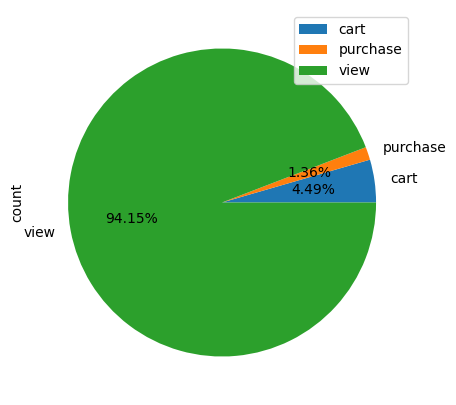

In [ ]:
events = df.groupBy('event_type').count().toPandas()
events.plot(kind='pie', y='count', labels=events['event_type'], autopct='%1.2f%%', figsize=(5, 5))

In [ ]:
df.select(f.countDistinct("product_id")).show()

+--------------------------+
|count(DISTINCT product_id)|
+--------------------------+
|                    190662|
+--------------------------+



In [ ]:
df.groupby('product_id').agg(f.collect_set('category_id'))\
                        .filter(size(col('collect_set(category_id)')) == 1).count()

190662

In [ ]:
df.select(f.countDistinct("category_id")).show()

+---------------------------+
|count(DISTINCT category_id)|
+---------------------------+
|                        684|
+---------------------------+



In [ ]:
df.drop_duplicates(subset=['category_id']).select(f.count("category_code")).show()

+--------------------+
|count(category_code)|
+--------------------+
|                 275|
+--------------------+



In [ ]:
df.select(f.countDistinct("category_code")).show()

+-----------------------------+
|count(DISTINCT category_code)|
+-----------------------------+
|                          129|
+-----------------------------+



In [ ]:
df.select(f.countDistinct("user_id")).show()

+-----------------------+
|count(DISTINCT user_id)|
+-----------------------+
|                3696117|
+-----------------------+



In [ ]:
df.select(f.countDistinct("user_session")).show()

+----------------------------+
|count(DISTINCT user_session)|
+----------------------------+
|                    13776050|
+----------------------------+



<Axes: xlabel='date'>

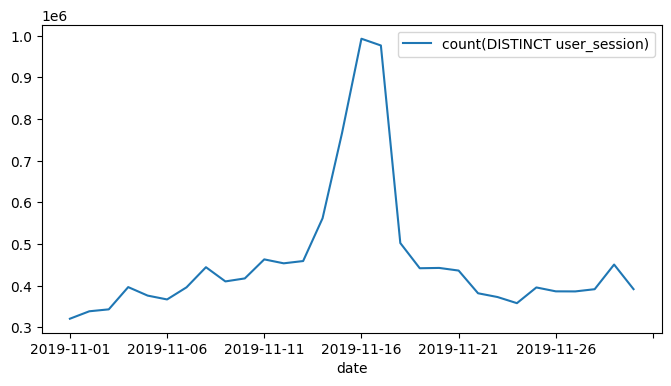

In [ ]:
df = df.withColumn('event_time', to_timestamp('event_time'))
df = df.withColumn('date', date_format("event_time", "yyyy-MM-dd"))

sessions = df.groupby('date').agg(countDistinct('user_session')).toPandas()
sessions.sort_values('date').plot(x='date', figsize=(8, 4))

In [ ]:
interactions = df.groupby(['user_id', 'product_id']).agg(sum(when(df['event_type'] == 'view', 1)).alias('views'),
                                                         sum(when(df['event_type'] == 'cart', 1)).alias('carts'),
                                                         sum(when(df['event_type'] == 'purchase', 1)).alias('purchases'))

interactions.sort('carts', ascending=False).show()

+---------+----------+-----+-----+---------+
|  user_id|product_id|views|carts|purchases|
+---------+----------+-----+-----+---------+
|512875426|  15300303|    2|  709|     NULL|
|521558076|   1005008|   18|  554|        1|
|571769879|  12720043|    5|  354|        1|
|513824664|   3601489|   12|  273|     NULL|
|515642515|  13101546|   38|  237|     NULL|
|564808105|   1002633|   22|  210|     NULL|
|564068124|   1004833|  294|  207|      216|
|513754375|  50600004|    6|  203|     NULL|
|514553781|   1004856|    4|  192|        1|
|515911561|   1004858|    7|  191|     NULL|
|557590749|   8800045|    2|  186|     NULL|
|549030056|   1004856|  193|  181|      118|
|559057489|   3700912|    2|  174|     NULL|
|538042220|  12720092|    2|  168|        1|
|515793237|  22700078|   31|  164|     NULL|
|543128872|   4804056|  190|  154|      150|
|515032042|   1004873|   19|  152|        1|
|571683521|   1004870|   16|  151|        1|
|518514099|   1005116|  158|  147|      140|
|564068124

## Preprocess

In [ ]:
def preprocess(df):

    # Update data types
    df = df.withColumn('event_time', to_timestamp('event_time'))
    df = df.withColumn('user_id', col('user_id').cast('integer'))
    df = df.withColumn('product_id', col('product_id').cast('integer'))
    df = df.withColumn('category_id', col('category_id').cast('long'))

    cart_df = df.filter(col('event_type') == 'cart')
    df = df.filter(col('event_type') != 'cart')
    cart_df = cart_df.dropDuplicates(subset=['product_id', 'user_id', 'user_session'])
    df = df.union(cart_df)

    return df

In [ ]:
df = preprocess(df)

## Feature Engineering

In [ ]:
def product_features(df):
    df = df.groupby('product_id').agg(first('category_id').alias('category_id'),
                                      first('category_code').alias('category_code'),
                                      count(when(df['event_type'] == 'view', True)).alias('views'),
                                      count(when(df['event_type'] == 'cart', True)).alias('carts'),
                                      count(when(df['event_type'] == 'purchase', True)).alias('purchases'),
                                      mean('price').alias('price'),
                                      min('event_time').alias('first_date'),
                                      max('event_time').alias('last_date'))

    df = df.withColumn('purchase_per_view', df['purchases'] / df['views'])
    df = df.withColumn('cart_per_view', df['carts'] / df['views'])
    df = df.withColumn('purchase_per_cart', when(df['carts'] == 0, df['purchases']).otherwise(df['purchases'] / df['carts']))

    return df

In [ ]:
def category_features(df):
    products = df.dropDuplicates(subset=['product_id'])
    products = products.groupby('category_id').agg(avg('price').alias('average_price'))

    df = df.groupby('category_id').agg(first('category_code').alias('category_code'),
                                       countDistinct('product_id').alias('number_of_products'),
                                       count(when(df['event_type'] == 'view', True)).alias('views'),
                                       count(when(df['event_type'] == 'cart', True)).alias('carts'),
                                       count(when(df['event_type'] == 'purchase', True)).alias('purchases'))

    df = df.withColumn('purchase_per_view', df['purchases'] / df['views'])
    df = df.withColumn('cart_per_view', df['carts'] / df['views'])
    df = df.withColumn('purchase_per_cart', when(df['carts'] == 0, df['purchases']).otherwise(df['purchases'] / df['carts']))

    df = df.join(products, on='category_id')

    return df

In [ ]:
def user_features(df):
    df = df.groupby('user_id').agg(count(when(df['event_type'] == 'view', True)).alias('views'),
                                   count(when(df['event_type'] == 'cart', True)).alias('carts'),
                                   count(when(df['event_type'] == 'purchase', True)).alias('purchases'),
                                   countDistinct(when(df['event_type'] == 'view', col('product_id'))).alias('distinct_products_viewed'),
                                   countDistinct(when(df['event_type'] == 'cart', col('product_id'))).alias('distinct_products_carted'),
                                   countDistinct(when(df['event_type'] == 'purchase', col('product_id'))).alias('distinct_products_purchased'),
                                   mean(when(df['event_type'] == 'view', col('price'))).alias('average_price_viewed'),
                                   mean(when(df['event_type'] == 'purchase', col('price'))).alias('average_price_purchased'),
                                   mean(when(df['event_type'] == 'view', col('relative_price'))).alias('avg_relative_price_viewed'),
                                   mean(when(df['event_type'] == 'purchase', col('relative_price'))).alias('avg_relative_price_purchased'),
                                   min('event_time').alias('first_date'),
                                   max('event_time').alias('last_date'))

    df = df.withColumn('purchase_per_view', when(df['views'] == 0, df['purchases']).otherwise(df['purchases'] / df['views']))
    df = df.withColumn('cart_per_view', when(df['views'] == 0, df['carts']).otherwise(df['carts'] / df['views']))
    df = df.withColumn('purchase_per_cart', when(df['carts'] == 0, df['purchases']).otherwise(df['purchases'] / df['carts']))

    return df

In [ ]:
def category_smoothener(categories, mean, attr, rate, min_sample_size=1000):
    categories = categories.withColumn(rate, when(categories[attr] < min_sample_size, ((categories[rate] * categories[attr]) + (mean * (min_sample_size - categories[attr]))) / min_sample_size).otherwise(categories[rate]))
    return categories

In [ ]:
def product_smoothener(products, categories, attr, rate, min_sample_size=1000):

    category_rate = rate + '_cat'
    categories = categories.withColumnRenamed(rate, category_rate)
    products = products.join(categories['category_id', category_rate], on='category_id')

    products = products.withColumn(rate, when(products[attr] < min_sample_size, ((products[rate] * products[attr]) + (products[category_rate] * (min_sample_size - products[attr]))) / min_sample_size).otherwise(products[rate]))

    products = products.drop(category_rate)
    return products

In [ ]:
def calculate_relative_price(products):

    categories = products.groupby('category_id').agg(percentile_approx('price', 0.25, 1000).alias('Q1'),
                                                     percentile_approx('price', 0.5, 1000).alias('median'),
                                                     percentile_approx('price', 0.75, 1000).alias('Q3'))

    categories = categories.withColumn('IQR', col('Q3') - col('Q1'))
    categories = categories.withColumn('IQR', when(col('IQR') < 1, 1).otherwise(col('IQR')))

    products = products.join(categories, on='category_id')
    products = products.withColumn('relative_price', (col('price') - col('median')) / col('IQR'))

    products = products.withColumn('relative_price', when(col('relative_price') > 5, 5).otherwise(col('relative_price')))

    products = products.withColumn('relative_price', when(col('relative_price') < -5, -5).otherwise(col('relative_price')))

    products = products.select('product_id', 'relative_price')
    return products

In [ ]:
products = product_features(df)
categories = category_features(df)
relative_prices = calculate_relative_price(products)

df = df.join(relative_prices, on='product_id')
products = products.join(relative_prices, on='product_id')

avg_purchase_per_view = events[events['event_type'] == 'purchase']['count'].values[0] / events[events['event_type'] == 'view']['count'].values[0]
avg_cart_per_view = events[events['event_type'] == 'cart']['count'].values[0] / events[events['event_type'] == 'view']['count'].values[0]
avg_purchase_per_cart = events[events['event_type'] == 'purchase']['count'].values[0] / events[events['event_type'] == 'cart']['count'].values[0]

categories = category_smoothener(categories, avg_purchase_per_view, 'views', 'purchase_per_view', 2000)
categories = category_smoothener(categories, avg_cart_per_view, 'views', 'cart_per_view', 2000)
categories = category_smoothener(categories, avg_purchase_per_cart, 'carts', 'purchase_per_cart', 200)
products = product_smoothener(products, categories, 'views', 'purchase_per_view', 1000)
products = product_smoothener(products, categories, 'views', 'cart_per_view', 1000)
products = product_smoothener(products, categories, 'carts', 'purchase_per_cart', 100)
users = user_features(df)

In [ ]:
products.sort('purchases', ascending=False).toPandas().head(50)

,category_id,product_id,category_code,views,carts,purchases,price,first_date,last_date,purchase_per_view,cart_per_view,purchase_per_cart,relative_price
0,2053013555631882655,1004856,electronics.smartphone,522880,51709,32321,127.285916,2019-11-01 00:00:23,2019-11-30 23:57:05,0.061813,0.098893,0.625056,-0.243029
1,2053013555631882655,1004767,electronics.smartphone,482898,40776,22613,245.660016,2019-11-01 00:00:30,2019-11-30 23:58:57,0.046828,0.084440,0.554566,0.072242
2,2053013555631882655,1005115,electronics.smartphone,583010,44398,22244,923.553354,2019-11-01 00:00:10,2019-11-30 23:57:19,0.038154,0.076153,0.501014,1.877710
3,2053013554658804075,4804056,electronics.audio.headphone,318339,34684,17800,162.846331,2019-11-01 00:01:30,2019-11-30 23:59:11,0.055915,0.108953,0.513205,1.752062
4,2053013555631882655,1004833,electronics.smartphone,247446,21362,13486,170.689336,2019-11-01 00:00:49,2019-11-30 23:59:59,0.054501,0.086330,0.631308,-0.127431
5,2053013555631882655,1002544,electronics.smartphone,229920,19094,11678,475.860346,2019-11-01 00:00:14,2019-11-30 23:57:42,0.050792,0.083046,0.611606,0.685347
6,2053013555631882655,1004870,electronics.smartphone,272097,21644,10673,282.161473,2019-11-01 00:01:33,2019-11-30 23:50:07,0.039225,0.079545,0.493116,0.169459
7,2053013555631882655,1005100,electronics.smartphone,216374,17962,10132,136.236611,2019-11-01 00:03:21,2019-11-30 23:57:33,0.046826,0.083014,0.564080,-0.219191
8,2053013555631882655,1004249,electronics.smartphone,254931,17225,8881,758.719656,2019-11-01 00:02:38,2019-11-30 23:59:11,0.034837,0.067567,0.515588,1.438700
9,2053013555631882655,1005105,electronics.smartphone,275721,15914,8483,1351.403351,2019-11-01 00:03:27,2019-11-30 23:59:38,0.030767,0.057718,0.533053,3.017225


## Collaborative Filtering

In [ ]:
last_date = df.agg(max('event_time')).collect()[0][0]
df = df.withColumn('last_date', lit(last_date))

df = df.withColumn('recency', (col('last_date').cast('double') - col('event_time').cast('double')) / 86400)
df = df.drop('last_date')

df = df.withColumn('recency_coef', expr('exp(ln(0.5)*recency/20)'))

In [ ]:
interactions = df.groupby(['user_id', 'product_id']).agg(sum(when(df['event_type'] == 'view', 1) * df['recency_coef']).alias('views'),
                                                         sum(when(df['event_type'] == 'cart', 1) * df['recency_coef']).alias('carts'),
                                                         sum(when(df['event_type'] == 'purchase', 1) * df['recency_coef']).alias('purchases'))
interactions = interactions.na.fill(0)

In [ ]:
def calculate_interaction_matrix(df, view_weight=0.1, cart_weight=0.3, purchase_weight=1.0):

    df = df.withColumn('interaction', view_weight * col('views') + cart_weight * col('carts') + purchase_weight * col('purchases'))

    df = df.withColumn('interaction', log10(col('interaction') + 1))

    df = df.withColumn('interaction', when(col('interaction') > 2, 2).otherwise(col('interaction')))

    return df

interaction_matrix = calculate_interaction_matrix(interactions)

In [ ]:
interaction_matrix.sort('interaction', ascending=False).show()

+---------+----------+------------------+------------------+------------------+------------------+
|  user_id|product_id|             views|             carts|         purchases|       interaction|
+---------+----------+------------------+------------------+------------------+------------------+
|549030056|   1004856|118.77629885902095|62.657110294156816| 71.00154722881302|               2.0|
|564068124|   1004833|139.54991783915665| 33.93168190423818| 99.65625067729745|               2.0|
|552639168|   4100346|142.36639228501605| 66.44439531146062| 77.03626179428448|               2.0|
|518514099|   1005116| 99.37373946113752|13.175932454920725| 88.01711693417916|               2.0|
|543128872|   4804056|168.97402855276016|28.793344970527357| 134.8246254453266|               2.0|
|564068124|   1004767| 99.10566057156981|21.353469680092054| 68.77746116880749|1.9349732296515765|
|549385752|   4804056|105.15837234341382|26.966968912974835|57.385810309866244|1.8864441246686523|
|513637414

In [ ]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

def cross_validate_als(interaction_matrix):

    als = ALS(userCol='user_id', itemCol='product_id', ratingCol='interaction',
              nonnegative=True, coldStartStrategy='drop', implicitPrefs=True)

    param_grid = ParamGridBuilder() \
        .addGrid(als.rank, [5, 10, 15, 20]) \
        .addGrid(als.regParam, [0.005, 0.01, 0.05, 0.1]) \
        .addGrid(als.alpha, [0, 1.0, 5.0]) \
        .build()

    evaluator = RegressionEvaluator(metricName='rmse', labelCol='interaction', predictionCol='prediction')
    cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5, collectSubModels=False)
    pipeline = Pipeline(stages=[cv])
    model = pipeline.fit(interaction_matrix)

    return model

In [ ]:
model = cross_validate_als(interaction_matrix)

bestModel = model.stages[0].bestModel

predictions = bestModel.transform(interaction_matrix)

evaluator = RegressionEvaluator(metricName='rmse', labelCol='interaction', predictionCol='prediction')
rmse = evaluator.setMetricName('rmse').evaluate(predictions)
mae = evaluator.setMetricName('mae').evaluate(predictions)
print(' rmse:' + str(rmse) + ' mae:' + str(mae))

regParam = bestModel._java_obj.parent().getRegParam()
rank = bestModel._java_obj.parent().getRank()
alpha = bestModel._java_obj.parent().getAlpha()
print('rank:' + str(rank) + ' regParam:' + str(regParam) + ' alpha:' + str(alpha))

In [ ]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

def simple_als(interaction_matrix):

    (train, test) = interaction_matrix.randomSplit([0.8, 0.2])

    als = ALS(userCol='user_id', itemCol='product_id', ratingCol='interaction',
              alpha=1, regParam=0.005, rank=15, implicitPrefs=True,
              nonnegative=True, coldStartStrategy='drop')

    model = als.fit(train)

    predictions = model.transform(test)
    evaluator = RegressionEvaluator(metricName='rmse', labelCol='interaction', predictionCol='prediction')
    rmse = evaluator.evaluate(predictions)
    mae = evaluator.setMetricName('mae').evaluate(predictions)
    print('test rmse:' + str(rmse) + ' mae:' + str(mae))

    return model

In [ ]:
als_model = simple_als(interaction_matrix)

test rmse:0.0928369745772974 mae:0.05432642733033301


## Recommend Products for Users

In [ ]:
user_subset = [565606905, 570112140, 564068124]
recommendations = sc.createDataFrame([(user, 0) for user in user_subset], ['user_id', 'product_id'])
recommendations = als_model.recommendForUserSubset(recommendations, 500)

In [ ]:
recommendations.show()

+---------+--------------------+
|  user_id|     recommendations|
+---------+--------------------+
|570112140|[{1004833, 0.5887...|
|565606905|[{1005115, 0.9853...|
|564068124|[{1004873, 1.0589...|
+---------+--------------------+



In [ ]:
recs_for_user_1 = sc.createDataFrame(recommendations.collect()[1][1])

In [ ]:
interactions.filter(col('user_id') == 564068124).sort('purchases', ascending=False).show()

+---------+----------+------------------+-------------------+------------------+
|  user_id|product_id|             views|              carts|         purchases|
+---------+----------+------------------+-------------------+------------------+
|564068124|   1004833|139.54991783915662|  33.93168190423818| 99.65625067729746|
|564068124|   1004767| 99.10566057156984|  21.35346968009205| 68.77746116880749|
|564068124|   1004856|22.286414097085476|  5.485494261870614|12.006362990183272|
|564068124|   1004870|12.360455924522274| 2.8240715924850974|  8.56032828206366|
|564068124|   1004873|10.745808997156987| 2.9390547109247525|  8.01436540346296|
|564068124|   1005115| 9.649142656908744| 1.1602375014526323| 6.924999866007589|
|564068124|   1003525| 5.740135679629443|                0.0| 4.576104202695865|
|564068124|   1004875| 5.359923757611487|   0.89632110532636| 4.463581838693649|
|564068124|   1307310| 3.429727471133744|  1.795425924579977|2.6126704924519952|
|564068124|   1004858|2.8272

In [ ]:
def calculate_recommendation_scores_for_user(user_id, recs, products, users, coef_als_score=0.8, coef_conversion_rate=0.1, coef_spending_habit=0.1, coef_spending_booster=0.05):
    recs = recs.join(products['product_id', 'purchase_per_view', 'relative_price'], on='product_id')
    user_avg_relative_price = users.filter(col('user_id') == user_id)['user_id', 'avg_relative_price_purchased'].collect()[0][1]
    recs = recs.withColumn('rating', col('rating') / 2)
    recs = recs.withColumn('purchase_per_view', col('purchase_per_view') / 0.075)
    recs = recs.withColumn('relative_price', (col('relative_price') + 5) / 10)
    user_avg_relative_price = (user_avg_relative_price + 1) / 2
    recs = recs.withColumn('recommendation_score', ((recs['rating'] * coef_als_score) + (recs['purchase_per_view'] * coef_conversion_rate) - abs(user_avg_relative_price + coef_spending_booster - recs['relative_price']) * coef_spending_habit) / (coef_als_score + coef_conversion_rate + coef_spending_habit))
    recs = recs.withColumn('rating', col('rating') * 2)
    recs = recs.withColumn('purchase_per_view', col('purchase_per_view') * 0.075)
    recs = recs.withColumn('relative_price', col('relative_price') * 2 - 1)
    user_avg_relative_price = user_avg_relative_price * 10 - 5

    return recs

In [ ]:
recs_user = calculate_recommendation_scores_for_user(564068124, recs_for_user_1, products, users)

In [ ]:
recs_user.sort('recommendation_score', ascending=False).show()

+----------+--------------------+--------------------+--------------------+--------------------+
|product_id|              rating|   purchase_per_view|      relative_price|recommendation_score|
+----------+--------------------+--------------------+--------------------+--------------------+
|   1004767|  0.9750394225120544| 0.04682769446135623| 0.01444848433599133|  0.4440904726154273|
|   1005115|  0.9853531122207642|0.038153719490231726|  0.3755420579370299| 0.43532041453309894|
|   1005105|  0.9283467531204224|0.030766608274306273|  0.6034449976962315|  0.3912732422837682|
|   1002544| 0.22544562816619873|0.050791579679888656|  0.1370693376880836| 0.15566917783606612|
|   4804056| 0.06504727900028229|0.055915235016758866|  0.3504124335836738| 0.09213658316461013|
|   1002524| 0.05744624510407448| 0.04750022822018684| 0.17715587613694495| 0.08608528292072375|
|   1002633| 0.07430935651063919| 0.04402449827121454| 0.08567578305186885| 0.08362221623046609|
|   1005135| 0.171642065048217

In [ ]:
non_interacted_products = recs_user.join(interactions.filter(col('user_id') == 564068124), on='product_id', how='leftanti')
non_interacted_products.sort('recommendation_score', ascending=False).show()

+----------+--------------------+--------------------+--------------------+--------------------+
|product_id|              rating|   purchase_per_view|      relative_price|recommendation_score|
+----------+--------------------+--------------------+--------------------+--------------------+
|   1005105|  0.9283467531204224|0.030766608274306273|  0.6034449976962315|  0.3912732422837682|
|   4804056| 0.06504727900028229|0.055915235016758866|  0.3504124335836738| 0.09213658316461013|
|   1002524| 0.05744624510407448| 0.04750022822018684| 0.17715587613694495| 0.08608528292072375|
|   1002633| 0.07430935651063919| 0.04402449827121454| 0.08567578305186885| 0.08362221623046609|
|   1005135| 0.17164206504821777| 0.03130572038233317|  0.7636747121888816| 0.08129869747428968|
|   1004838|  0.1060510128736496| 0.03380885021885342|-0.02991104390592...| 0.07691867335796597|
|  10701101|0.006446830928325653|0.051646529258469555|  0.2013256331084805| 0.07045913628186806|
|   1004836|0.0474205762147903

## Recommend Similar Products

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Normalizer
from pyspark.ml.feature import SQLTransformer

product_vectors = als_model.itemFactors
product_vectors = product_vectors.rdd.map(lambda row: (row[0], Vectors.dense(row[1])))
product_vectors = product_vectors.toDF(['product_id', 'features'])

assembler = VectorAssembler(inputCols=['features'], outputCol='vector')
product_vectors = assembler.transform(product_vectors)

normalizer = Normalizer(inputCol='vector', outputCol='norm_vector')
product_vectors = normalizer.transform(product_vectors)

product_vector = product_vectors.where(col('product_id') == 5100067).select('norm_vector').collect()[0][0]
product_vector

DenseVector([0.0, 0.0, 0.2427, 0.0563, 0.0, 0.0, 0.0011, 0.4784, 0.111, 0.2474, 0.0904, 0.008, 0.1202, 0.7829, 0.0])

In [ ]:
from pyspark.ml.feature import BucketedRandomProjectionLSH

brp = BucketedRandomProjectionLSH(inputCol="norm_vector", outputCol="neighbors", numHashTables=5, bucketLength=0.1)
brp_model = brp.fit(product_vectors)
query = product_vectors.filter(col('product_id') == 5100067).select('norm_vector').first()[0]
neighbors = brp_model.approxNearestNeighbors(product_vectors, query, numNearestNeighbors=50)

In [ ]:
neighbors.select('product_id', 'distCol').show(truncate=False)

+----------+-------------------+
|product_id|distCol            |
+----------+-------------------+
|5100067   |0.0                |
|5100343   |0.08841860213508962|
|5100505   |0.09861238244765123|
|5100604   |0.10482159743434806|
|5100346   |0.11965644360949981|
|5100338   |0.12016250786569516|
|5100562   |0.12352265884596454|
|5100689   |0.1362194636553884 |
|5100365   |0.14253535750289695|
|5100576   |0.15033471982236105|
|5100572   |0.1529031172279817 |
|5100337   |0.15586511816257986|
|5100735   |0.15739057634411044|
|5100570   |0.16056365061802622|
|5100574   |0.1644178657566772 |
|5100571   |0.1648571356009112 |
|5100610   |0.1675802040172355 |
|5100575   |0.16923975581189366|
|40500173  |0.17233112328410555|
|5100351   |0.18776271975242348|
+----------+-------------------+
only showing top 20 rows



In [ ]:
def calculate_recommendation_scores_for_products(recs, products, coef_distance_score=0.8, coef_conversion_rate=0.1, coef_relative_price=0.1, coef_spending_booster=0.05):
    recs = recs.join(products['product_id', 'purchase_per_view', 'relative_price'], on='product_id')
    recs = recs.withColumn('distCol', (math.sqrt(2) - col('distCol')) / math.sqrt(2))
    recs = recs.withColumn('purchase_per_view', col('purchase_per_view') / 0.075)
    recs = recs.withColumn('relative_price', (col('relative_price') + 5) / 10)
    product_relative_price = recs.filter(col('distCol') == 1)['product_id', 'relative_price'].collect()[0][1]
    product_relative_price = (product_relative_price + 5) / 10
    recs = recs.withColumn('recommendation_score', ((recs['distCol'] * coef_distance_score) + (recs['purchase_per_view'] * coef_conversion_rate) - abs(product_relative_price + coef_spending_booster - recs['relative_price']) * coef_relative_price) / (coef_distance_score + coef_conversion_rate + coef_relative_price))
    recs = recs.filter(col('distCol') != 1)
    recs = recs.withColumn('distCol', math.sqrt(2) - col('distCol') * math.sqrt(2))
    recs = recs.withColumn('purchase_per_view', col('purchase_per_view') * 0.075)
    recs = recs.withColumn('relative_price', col('relative_price') * 10 - 5)
    product_relative_price = product_relative_price * 10 - 5

    return recs

In [ ]:
recs_product = calculate_recommendation_scores_for_products(neighbors.select('product_id', 'distCol'), products)

In [ ]:
recs_product.sort('recommendation_score', ascending=False).toPandas() \
    .style.bar(color='lightgreen', subset='distCol') \
    .bar(color='pink', subset='purchase_per_view') \
    .bar(color='tan', subset='relative_price') \
    .bar(color='lightblue', subset='recommendation_score')


,product_id,distCol,purchase_per_view,relative_price,recommendation_score
0,5100343,0.088419,0.034125,0.172782,0.787083
1,5100562,0.123523,0.045348,0.099933,0.781460
2,5100604,0.104822,0.034934,0.100170,0.778157
3,5100365,0.142535,0.039339,0.128554,0.762979
4,5100689,0.136219,0.035785,0.139820,0.761926
5,5100505,0.098612,0.017569,0.100222,0.758516
6,5100338,0.120163,0.026111,0.094215,0.757654
7,5100610,0.167580,0.039063,0.081039,0.747968
8,5100346,0.119656,0.015488,0.209387,0.744928
9,5100576,0.150335,0.026530,0.367609,0.743878


## Recommend Products to Users Viewing a Product

In [ ]:
recs_user = recs_user.withColumnRenamed('recommendation_score', 'recommendation_score_user')
recs_paired = recs_product.join(recs_user['product_id', 'recommendation_score_user'], on='product_id', how='left')

In [ ]:
min_user_score = recs_paired.select(min('recommendation_score_user')).collect()[0][0]
recs_paired = recs_paired.na.fill(min_user_score * 0.9)
recs_paired = recs_paired.withColumn('paired_score', col('recommendation_score') * 0.5 + col('recommendation_score_user') * 0.5)


In [ ]:
recs_paired.sort('paired_score', ascending=False).toPandas()\
           .head(50).style.bar(color='lightblue', subset='recommendation_score')\
           .bar(color='pink', subset='recommendation_score_user')\
           .bar(color='lightgreen', subset='paired_score')


,product_id,distCol,purchase_per_view,relative_price,recommendation_score,recommendation_score_user,paired_score
0,5100562,0.123523,0.045348,0.099933,0.781460,0.057046,0.419253
1,5100343,0.088419,0.034125,0.172782,0.787083,0.029403,0.408243
2,5100604,0.104822,0.034934,0.100170,0.778157,0.029403,0.403780
3,5100610,0.167580,0.039063,0.081039,0.747968,0.047142,0.397555
4,5100365,0.142535,0.039339,0.128554,0.762979,0.029403,0.396191
5,5100689,0.136219,0.035785,0.139820,0.761926,0.029403,0.395664
6,5100505,0.098612,0.017569,0.100222,0.758516,0.029403,0.393959
7,5100338,0.120163,0.026111,0.094215,0.757654,0.029403,0.393529
8,5100572,0.152903,0.026821,0.381558,0.742953,0.035628,0.389291
9,5100576,0.150335,0.026530,0.367609,0.743878,0.032670,0.388274


In [ ]:
als_model.save('/kaggle/working/best_als_model')

In [ ]:
from pyspark.ml.util import MLWritable, MLReadable
def save_ml_component(ml_component, path):
    ml_component.write().overwrite().save(path)

def load_ml_component(path):
    return MLReadable.load(path)



In [ ]:
users.write.csv("/kaggle/working/users.csv", header=True)
products.write.csv("/kaggle/working/products.csv", header=True)
product_vectors.write.parquet('/kaggle/working/product_vectors.parquet', header=True)

In [ ]:
save_ml_component(brp_model, '/kaggle/working/brp_model')

## Check for interpretability

In [ ]:
user_df = df.filter(col("user_id") == 564068124)
unique_combinations = user_df.select("product_id", "user_session").distinct()
final_df = unique_combinations.join(user_df.select("product_id", "user_session", "category_code"),
                                    ["product_id", "user_session"],
                                    "inner")

final_df.show()

+----------+--------------------+--------------------+
|product_id|        user_session|       category_code|
+----------+--------------------+--------------------+
|   1004767|fd4462c7-a672-49a...|electronics.smart...|
|   1004767|fd4462c7-a672-49a...|electronics.smart...|
|   1004767|fd4462c7-a672-49a...|electronics.smart...|
|   1004767|fd4462c7-a672-49a...|electronics.smart...|
|   1004767|fd4462c7-a672-49a...|electronics.smart...|
|   1004833|fd4462c7-a672-49a...|electronics.smart...|
|   1004833|fd4462c7-a672-49a...|electronics.smart...|
|   1004833|fd4462c7-a672-49a...|electronics.smart...|
|   1004833|fd4462c7-a672-49a...|electronics.smart...|
|   1004833|fd4462c7-a672-49a...|electronics.smart...|
|   1004833|fd4462c7-a672-49a...|electronics.smart...|
|   1004833|fd4462c7-a672-49a...|electronics.smart...|
|   1004833|fd4462c7-a672-49a...|electronics.smart...|
|   1004833|fd4462c7-a672-49a...|electronics.smart...|
|   1004767|a3ee6286-6eeb-4af...|electronics.smart...|
|   100476

In [ ]:
from pyspark.sql.functions import count
count_df = final_df.groupBy('category_code').agg(count('*').alias('count'))
count_df.show()

+--------------------+-----+
|       category_code|count|
+--------------------+-----+
|  computers.notebook|   24|
|  electronics.clocks|   29|
|  electronics.tablet|    6|
|electronics.smart...| 1343|
|electronics.audio...|    9|
|                NULL|    4|
+--------------------+-----+



In [ ]:
df.filter(col("product_id") == 4804056).select("category_code").show()

+--------------------+
|       category_code|
+--------------------+
|electronics.audio...|
|electronics.audio...|
|electronics.audio...|
|electronics.audio...|
|electronics.audio...|
|electronics.audio...|
|electronics.audio...|
|electronics.audio...|
|electronics.audio...|
|electronics.audio...|
|electronics.audio...|
|electronics.audio...|
|electronics.audio...|
|electronics.audio...|
|electronics.audio...|
|electronics.audio...|
|electronics.audio...|
|electronics.audio...|
|electronics.audio...|
|electronics.audio...|
+--------------------+
only showing top 20 rows



## For Cold Starting, we may use top 50 popular product or top 5 popular product from each category

In [ ]:
from pyspark.sql.functions import countDistinct

# Group by product ID and count distinct combinations of user ID and session ID
popular_items = df.groupBy("product_id").agg(countDistinct("user_id", "user_session").alias("unique_combinations"))

# Sort the DataFrame in descending order based on the count
popular_items = popular_items.orderBy("unique_combinations", ascending=False)

# Select the top 50 popular items
top_50_popular_items = popular_items.limit(50)

# Show the top 50 popular items
top_50_popular_items.show()


+----------+-------------------+
|product_id|unique_combinations|
+----------+-------------------+
|   1005115|             371610|
|   1004856|             338509|
|   1004767|             306151|
|   1005105|             192193|
|   4804056|             176264|
|   1005160|             171553|
|   1004249|             169430|
|   1004833|             163192|
|   1004870|             161358|
|   1002544|             160596|
|   1005100|             135904|
|   1004873|             122127|
|   1004836|             116292|
|   1005239|             110759|
|   4804718|             105936|
|   1005116|             100517|
|   5100816|              97655|
|   1005174|              95799|
|   1005135|              94470|
|   1004838|              93997|
+----------+-------------------+
only showing top 20 rows



In [ ]:
from pyspark.sql import Window
from pyspark.sql.functions import rank, col

# Define a window specification partitioned by category ID and ordered by the count of unique combinations
window_spec = Window.partitionBy("category_id").orderBy(col("unique_combinations").desc())

# Calculate the count of unique combinations of user ID and session ID for each product within each category
category_popular_items = df.groupBy("category_id", "product_id") \
                           .agg(countDistinct("user_id", "user_session").alias("unique_combinations"))

# Add a rank column based on the count of unique combinations within each category
category_popular_items = category_popular_items.withColumn("rank", rank().over(window_spec))

# Filter to keep only the top 5 popular products in each category
top_5_popular_in_each_category = category_popular_items.filter(col("rank") <= 5)

# Show the top 5 popular products in each category
top_5_popular_in_each_category.show()

+-------------------+----------+-------------------+----+
|        category_id|product_id|unique_combinations|rank|
+-------------------+----------+-------------------+----+
|2053013552226107603|   8600207|                256|   1|
|2053013552226107603|   8600036|                232|   2|
|2053013552226107603|   8600156|                207|   3|
|2053013552226107603|   8600175|                196|   4|
|2053013552226107603|   8600204|                115|   5|
|2053013552259662037|   8500140|               3287|   1|
|2053013552259662037|   8500461|               2736|   2|
|2053013552259662037|   8500247|               2295|   3|
|2053013552259662037|   8500131|               2294|   4|
|2053013552259662037|   8500187|               1998|   5|
|2053013552293216471|   6201019|               5015|   1|
|2053013552293216471|   6200806|               4857|   2|
|2053013552293216471|   6200514|               4653|   3|
|2053013552293216471|   6200724|               3477|   4|
|2053013552293